In [ ]:
!unzip TestDataSet.zip

In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
import shutil
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
def get_transforms():
    mean_norms = np.array([0.485, 0.456, 0.406])
    std_norms = np.array([0.229, 0.224, 0.225])

    plain_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_norms, std=std_norms)
    ])

    return plain_transforms

def denormalize(tensor):
    tensor = tensor.cpu()

    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return tensor * std + mean

In [3]:
def load_labels(json_path):
    with open(json_path, 'r') as f:
        labels = json.load(f)

    labels_list = []
    for label_entry in labels:
        index, class_name = label_entry.split(": ", 1)
        labels_list.append(class_name)

    return labels_list

def load_dataset(dataset_path, transform=None):
    if transform is None:
        transform = get_transforms()

    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
    return dataset


In [4]:
def save_adversarial_example(image, label, save_dir, idx, class_names):
    class_dir = os.path.join(save_dir, class_names[label])
    os.makedirs(class_dir, exist_ok=True)

    image = denormalize(image)
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image)

    image.save(os.path.join(class_dir, f'adv_{idx}.png'))

def create_adversarial_dataset(original_dataset, adversarial_images, labels, save_dir, class_names):
    os.makedirs(save_dir, exist_ok=True)

    shutil.copy(os.path.join('./TestDataSet', 'labels_list.json'),
                os.path.join(save_dir, 'labels_list.json'))

    for i, (image, label) in enumerate(zip(adversarial_images, labels)):
        save_adversarial_example(image, label, save_dir, i, class_names)


In [5]:
def visualize_adversarial_examples(original_images, adversarial_images, labels, model, device, num_examples=3):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(num_examples, 2, figsize=(10, 3*num_examples))

        for i in range(num_examples):
            # Original image
            orig_img = denormalize(original_images[i].unsqueeze(0))
            orig_pred = model(original_images[i].unsqueeze(0).to(device))
            orig_label = labels[i].item()
            orig_pred_label = orig_pred.argmax(dim=1).item()

            # Adversarial image
            adv_img = denormalize(adversarial_images[i].unsqueeze(0))
            adv_pred = model(adversarial_images[i].unsqueeze(0).to(device))
            adv_pred_label = adv_pred.argmax(dim=1).item()

            # Plot
            axes[i, 0].imshow(orig_img.squeeze(0).permute(1, 2, 0).cpu().numpy())
            axes[i, 0].set_title(f'Original\nTrue: {orig_label}\nPred: {orig_pred_label}')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(adv_img.squeeze(0).permute(1, 2, 0).cpu().numpy())
            axes[i, 1].set_title(f'Adversarial\nTrue: {orig_label}\nPred: {adv_pred_label}')
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

In [7]:
def calculate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    top5_correct = 0

    with torch.no_grad():
        for images, labels in dataloader:

            labels = labels + 401

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)
            top5_correct += top5_preds.eq(labels.view(-1, 1).expand_as(top5_preds)).sum().item()

    top1_accuracy = 100. * correct / total
    top5_accuracy = 100. * top5_correct / total

    return top1_accuracy, top5_accuracy

In [8]:
class FGSM:
    def __init__(self, model, epsilon=0.02):
        self.model = model
        self.epsilon = epsilon

    def attack(self, images, labels):
        images.requires_grad = True

        # Forward pass
        outputs = self.model(images)
        loss = F.cross_entropy(outputs, labels)

        # Backward pass
        self.model.zero_grad()
        loss.backward()

        # Creating adversarial examples
        with torch.no_grad():
            adversarial_images = images + self.epsilon * torch.sign(images.grad)

        return adversarial_images

In [9]:
class PGD:
    def __init__(self, model, epsilon=0.02, alpha=0.01, num_steps=10):
        self.model = model
        self.epsilon = epsilon
        self.alpha = alpha
        self.num_steps = num_steps

    def attack(self, images, labels):
        adversarial_images = images.clone().detach()

        for _ in range(self.num_steps):
            adversarial_images.requires_grad = True

            # Forward pass
            outputs = self.model(adversarial_images)
            loss = F.cross_entropy(outputs, labels)

            # Backward pass
            self.model.zero_grad()
            loss.backward()

            # Updating adversarial images
            with torch.no_grad():
                adversarial_images = adversarial_images + self.alpha * torch.sign(adversarial_images.grad)

        return adversarial_images

In [10]:
class PatchAttack:
    def __init__(self, model, epsilon=0.3, patch_size=32):
        self.model = model
        self.epsilon = epsilon
        self.patch_size = patch_size

    def attack(self, images, labels):
        batch_size = images.shape[0]
        device = images.device
        adversarial_images = images.clone()

        for i in range(batch_size):
            # Randomly selecting patch location
            h = np.random.randint(0, images.shape[2] - self.patch_size)
            w = np.random.randint(0, images.shape[3] - self.patch_size)

            # Creating random perturbation for the patch on the same device as input
            patch = torch.randn(3, self.patch_size, self.patch_size, device=device) * self.epsilon

            # Applying patch
            adversarial_images[i, :, h:h+self.patch_size, w:w+self.patch_size] += patch

        return adversarial_images

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Loading models
    resnet34 = models.resnet34(weights='IMAGENET1K_V1').to(device)
    densenet121 = models.densenet121(weights='IMAGENET1K_V1').to(device)

    # Loading dataset and labels
    dataset_path = "/content/TestDataSet"
    labels_path = os.path.join(dataset_path, "labels_list.json")
    class_names = load_labels(labels_path)
    dataset = load_dataset(dataset_path)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    #Evaluating original accuracy
    print("Evaluating original accuracy", end="\n\n")
    resnet_top1, resnet_top5 = calculate_accuracy(resnet34, dataloader, device)
    print(f"ResNet-34 Original Accuracy:\n\t Top 1: {resnet_top1:.2f}%, Top 5: {resnet_top5:.2f}%", end="\n\n")

    # FGSM Attack
    print("Implementing FGSM Attack", end="\n\n")
    resnet34 = models.resnet34(weights='IMAGENET1K_V1').to(device)
    fgsm_attack = FGSM(resnet34, epsilon=0.02)

    fgsm_dir = "AdversarialTestSet1"
    os.makedirs(fgsm_dir, exist_ok=True)

    all_fgsm_images = []
    all_fgsm_labels = []

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        adversarial_images = fgsm_attack.attack(images, labels)

        all_fgsm_images.extend(adversarial_images.cpu())
        all_fgsm_labels.extend(labels.cpu())

    create_adversarial_dataset(dataset, all_fgsm_images, all_fgsm_labels, fgsm_dir, class_names)

    fgsm_dataset = load_dataset(fgsm_dir)
    fgsm_dataloader = DataLoader(fgsm_dataset, batch_size=32, shuffle=False)
    fgsm_top1, fgsm_top5 = calculate_accuracy(resnet34, fgsm_dataloader, device)
    print(f"FGSM Attack Accuracy:\n\t Top 1: {fgsm_top1:.2f}%, Top 5: {fgsm_top5:.2f}%", end="\n\n")

    images, labels = next(iter(dataloader))
    labels += 401
    adversarial_images = fgsm_attack.attack(images.to(device), labels.to(device))
    visualize_adversarial_examples(images, adversarial_images, labels, resnet34, device, 5)

    # Improved Atack - PGD
    print("Implementing PGD Attack", end="\n\n")
    resnet34 = models.resnet34(weights='IMAGENET1K_V1').to(device)
    pgd_attack = PGD(resnet34, epsilon=0.02, alpha=0.01, num_steps=20)

    pgd_dir = "AdversarialTestSet2"
    os.makedirs(pgd_dir, exist_ok=True)

    all_pgd_images = []
    all_pgd_labels = []

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        adversarial_images = pgd_attack.attack(images, labels)

        all_pgd_images.extend(adversarial_images.cpu())
        all_pgd_labels.extend(labels.cpu())


    create_adversarial_dataset(dataset, all_pgd_images, all_pgd_labels, pgd_dir, class_names)

    pgd_dataset = load_dataset(pgd_dir)
    pgd_dataloader = DataLoader(pgd_dataset, batch_size=32, shuffle=False)
    pgd_top1, pgd_top5 = calculate_accuracy(resnet34, pgd_dataloader, device)
    print(f"PGD Attack Accuracy:\n\t Top 1: {pgd_top1:.2f}%, Top 5: {pgd_top5:.2f}%", end="\n\n")

    images, labels = next(iter(dataloader))
    labels += 401
    adversarial_images = pgd_attack.attack(images.to(device), labels.to(device))
    visualize_adversarial_examples(images, adversarial_images, labels, resnet34, device, 5)

    # Patch Attack
    print("Implementing Patch Attack", end="\n\n")
    resnet34 = models.resnet34(weights='IMAGENET1K_V1').to(device)
    patch_attack = PatchAttack(resnet34, epsilon=0.5, patch_size=32)

    patch_dir = "AdversarialTestSet3"
    os.makedirs(patch_dir, exist_ok=True)

    all_patch_images = []
    all_patch_labels = []

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        adversarial_images = patch_attack.attack(images, labels)

        all_patch_images.extend(adversarial_images.cpu())
        all_patch_labels.extend(labels.cpu())

    create_adversarial_dataset(dataset, all_patch_images, all_patch_labels, patch_dir, class_names)

    patch_dataset = load_dataset(patch_dir)
    patch_dataloader = DataLoader(patch_dataset, batch_size=32, shuffle=False)
    patch_top1, patch_top5 = calculate_accuracy(resnet34, patch_dataloader, device)
    print(f"Patch Attack Accuracy:\n\t Top 1: {patch_top1:.2f}%, Top 5: {patch_top5:.2f}%", end="\n\n")

    images, labels = next(iter(dataloader))
    labels += 401
    adversarial_images = patch_attack.attack(images.to(device), labels.to(device))
    visualize_adversarial_examples(images, adversarial_images, labels, resnet34, device, 5)


    # Final Evaluations on DenseNet-121
    print("Evaluating Transferability")

    orig_top1, orig_top5 = calculate_accuracy(densenet121, dataloader, device)
    print(f"DenseNet-121 Original Accuracy:\n\t Top-1: {orig_top1:.2f}%, Top-5: {orig_top5:.2f}%", end="\n\n")

    fgsm_top1, fgsm_top5 = calculate_accuracy(densenet121, fgsm_dataloader, device)
    print(f"DenseNet-121 FGSM Accuracy:\n\t Top 1: {fgsm_top1:.2f}%, Top 5: {fgsm_top5:.2f}%", end="\n\n")

    pgd_top1, pgd_top5 = calculate_accuracy(densenet121, pgd_dataloader, device)
    print(f"DenseNet-121 PGD Accuracy:\n\t Top 1: {pgd_top1:.2f}%, Top 5: {pgd_top5:.2f}%", end="\n\n")

    patch_top1, patch_top5 = calculate_accuracy(densenet121, patch_dataloader, device)
    print(f"DenseNet-121 Patch Accuracy:\n\t Top 1: {patch_top1:.2f}%, Top 5: {patch_top5:.2f}%", end="\n\n")


Using device: cuda
Evaluating original accuracy

ResNet-34 Original Accuracy:
	 Top 1: 76.00%, Top 5: 94.20%

Implementing FGSM Attack



100%|██████████| 16/16 [00:03<00:00,  4.69it/s]


FGSM Attack Accuracy:
	 Top 1: 2.00%, Top 5: 4.80%



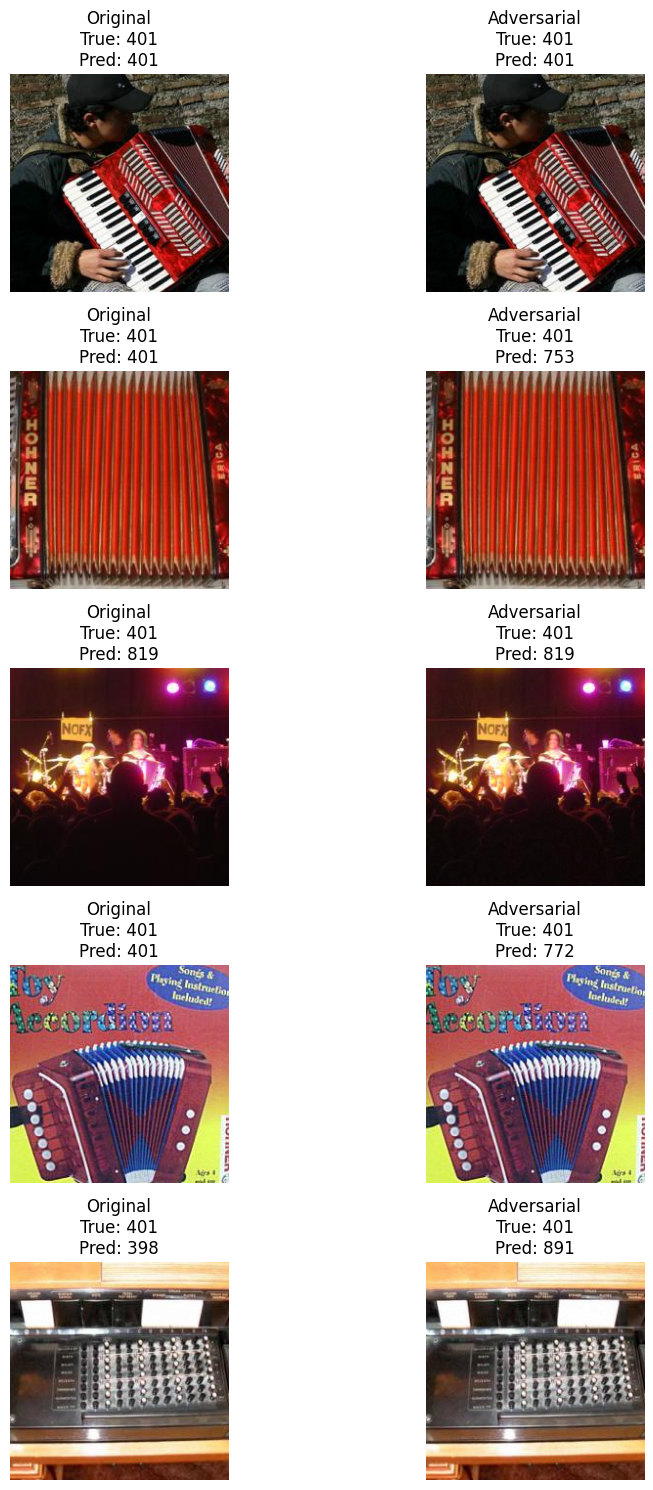

Implementing PGD Attack



100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


PGD Attack Accuracy:
	 Top 1: 1.80%, Top 5: 3.40%



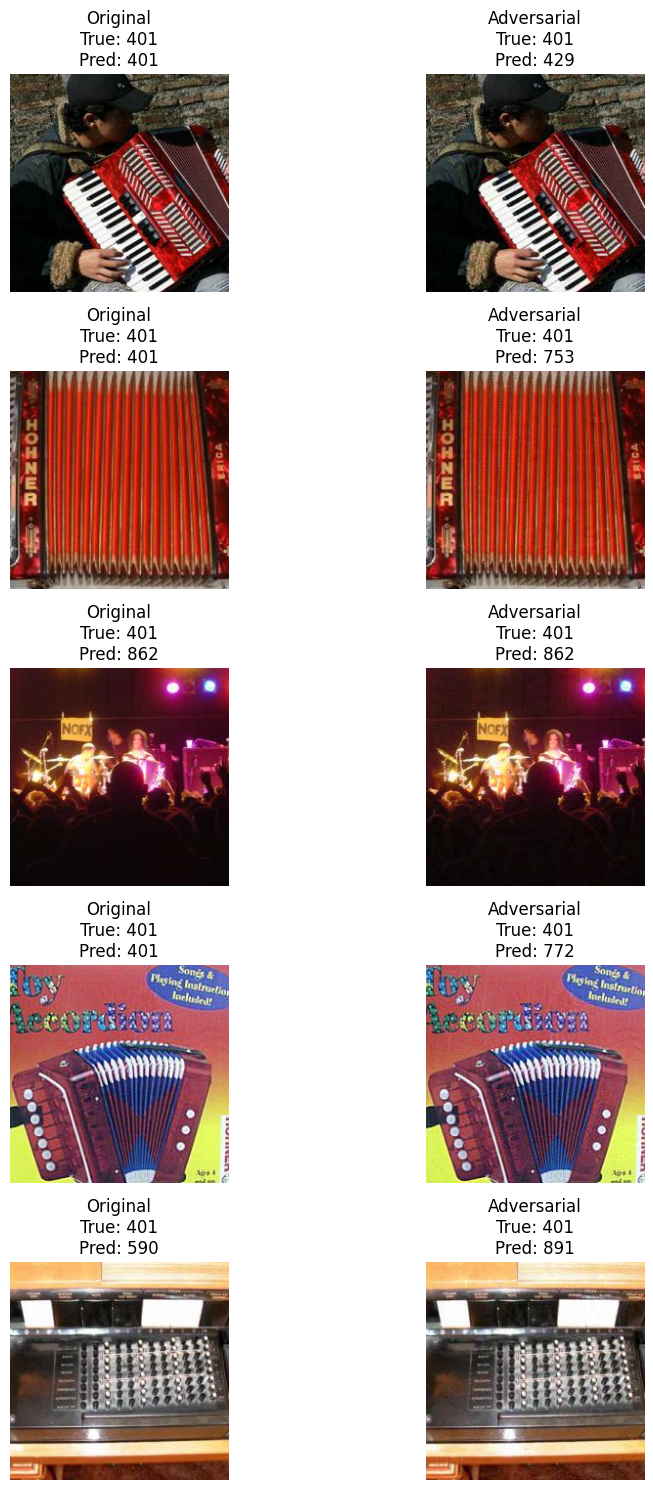

Implementing Patch Attack



100%|██████████| 16/16 [00:01<00:00, 14.88it/s]


Patch Attack Accuracy:
	 Top 1: 3.80%, Top 5: 5.40%



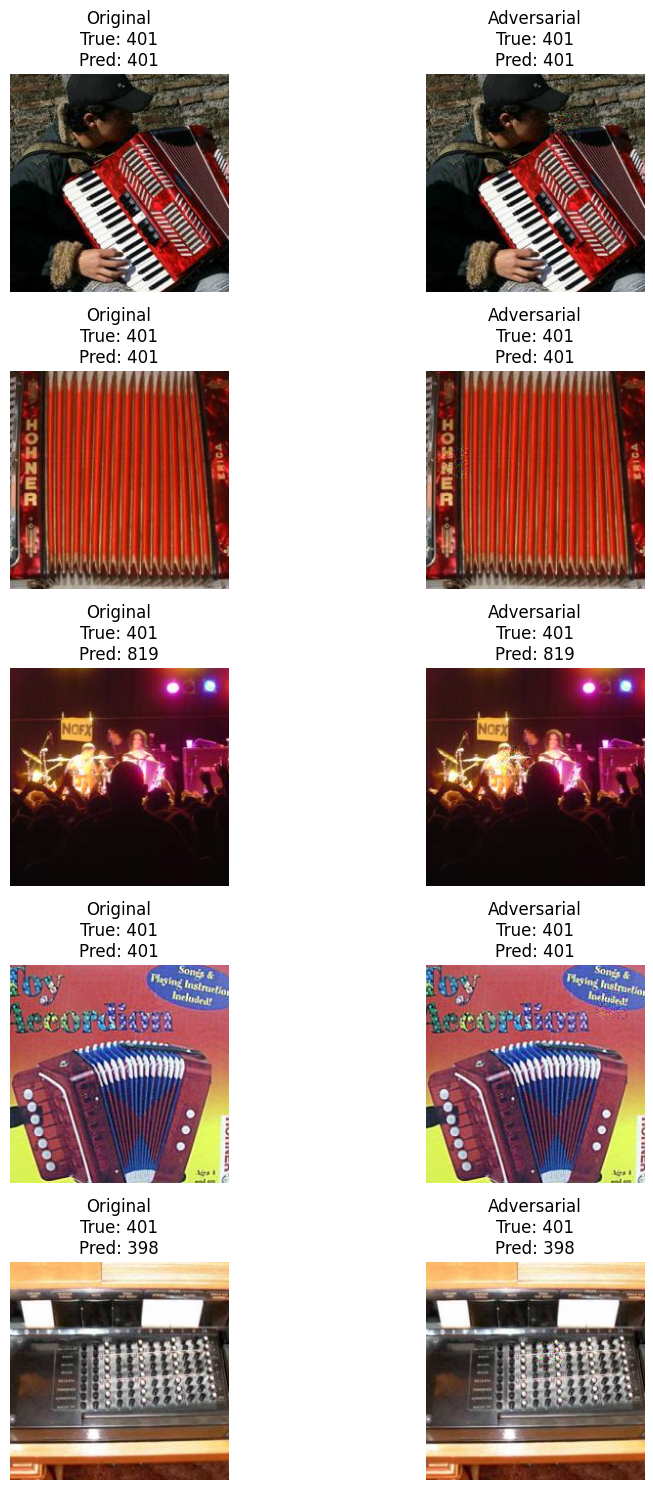

Evaluating Transferability
DenseNet-121 Original Accuracy:
	 Top-1: 74.80%, Top-5: 93.60%

DenseNet-121 FGSM Accuracy:
	 Top 1: 3.40%, Top 5: 6.00%

DenseNet-121 PGD Accuracy:
	 Top 1: 3.00%, Top 5: 4.80%

DenseNet-121 Patch Accuracy:
	 Top 1: 3.80%, Top 5: 6.40%



In [13]:
if __name__ == "__main__":
    main()